Временные ряды - финальный проект
====

Основное задание
---

В данном проекте главной задачей будет построить алгоритм, определяющий поиски аномалий.

Можно так же сделать симуляцию своей системы, то есть проверить, как система работала бы в продакшине, какие данные она бы использовала для перетренировки и как часто эта перетренировка бы соврешалась.

**На выбор** у вас два датасета. Один имеет много данных, а второй  временной ряд наоборот, содержат в себе еще очень мало информации. Вы так же можете использовать и другие датасеты из тех, что у вас есть в доступе на гитхабе. Но тогда вам прийдется сформулировать и ту задачу, которую вы пытаетесь решить, а именно пояснить, зачем в данном случае нам нужен поиск аномалий и как это будет применено на практике. 


Датасеты
------

Пассажиропоток нью-йоркского такси
--


In [157]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing   
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from mpl_toolkits.mplot3d import Axes3D
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})

In [158]:
df = pd.read_csv('datatest/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


<AxesSubplot:>

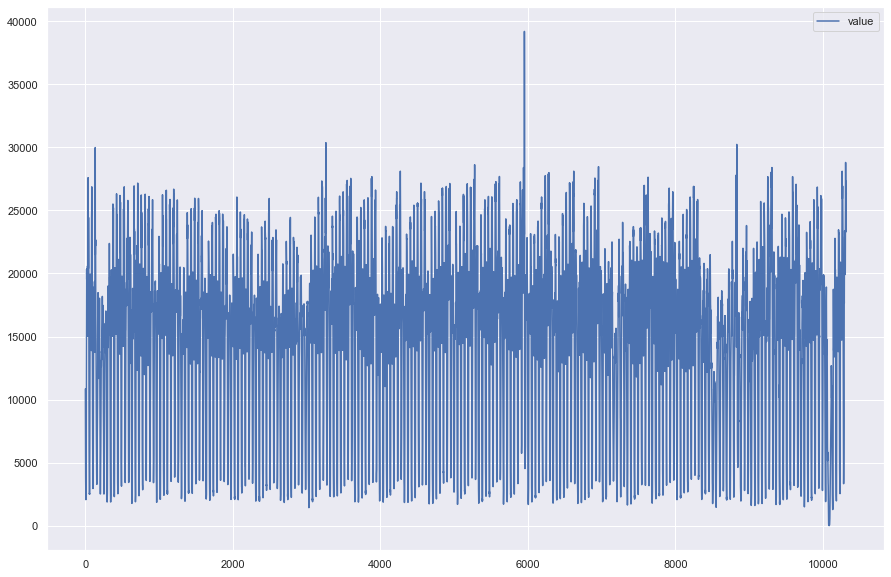

In [159]:
df.plot()

Данные за период с Июля, 2014 года по Январь, 2015. Агрегированы с интервалом в 30 минут.

Задание:
----

* Агрегировать данные по 1 часу
* Построить алгоритм определения аномалий с задержкой в 24 часа







In [160]:
df['timestamp']=pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df.set_index('timestamp',inplace=True)

In [161]:
df2 = df.resample('H').mean()
df2['hour'] = df2['hour'].astype(int)
df2.head()

,value,hour
timestamp,,
2014-07-01 00:00:00,9485.5,0
2014-07-01 01:00:00,5433.0,1
2014-07-01 02:00:00,3346.5,2
2014-07-01 03:00:00,2216.5,3
2014-07-01 04:00:00,2189.5,4


<AxesSubplot:>

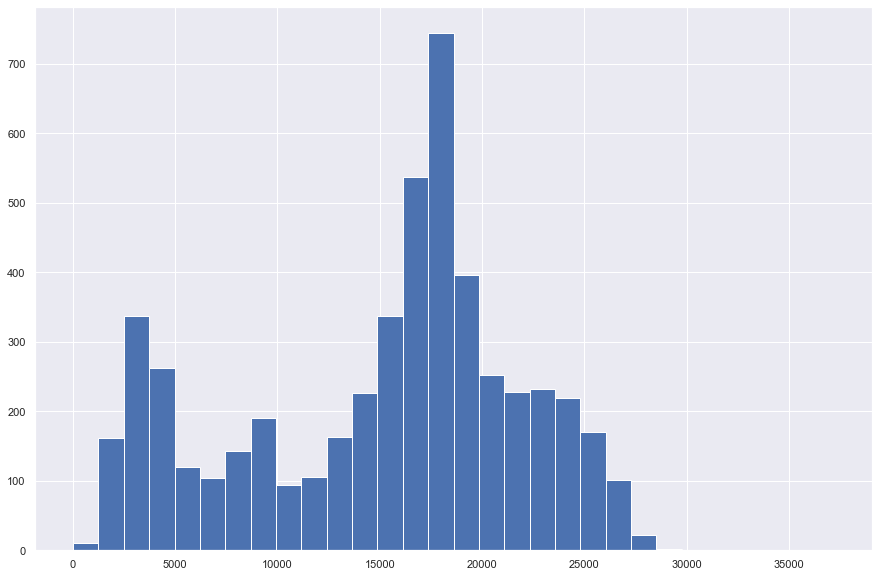

In [162]:
df2['value'].hist(bins=30)

In [163]:
df2.describe()

,value,hour
count,5160.000000,5160.000000
mean,15137.569380,11.500000
std,6879.890431,6.922857
min,9.500000,0.000000
25%,9547.875000,5.750000
50%,16913.000000,11.500000
75%,19641.125000,17.250000
max,37204.500000,23.000000


# Бачимо максимальне значення в даних 39197, яке є аномальним, формуємо дані без нього

In [164]:
df2 = df2.loc[(df2['value'] < 37204)]

# Умовно поділемо дані на години час пік (з 7 до 9 та з 16 до 18) та години спокою

In [165]:
busy_hours = [7, 8, 9, 16, 17, 18]
not_busy_hours = [22,23, 0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 19, 20, 21]

In [166]:
df2['busy_time_bool'] = df2['hour']

In [167]:
for i in range(len(df2['hour'])):
    if df2['busy_time_bool'][i] in busy_hours:
        df2['busy_time_bool'][i] = 1
    else:
        df2['busy_time_bool'][i] = 0
        
    

In [168]:
train, test = df2[0:-24], df2[-24:]

In [169]:
a = df2.loc[df2['busy_time_bool'] == 0, 'value']
b = df2.loc[df2['busy_time_bool'] == 1, 'value']

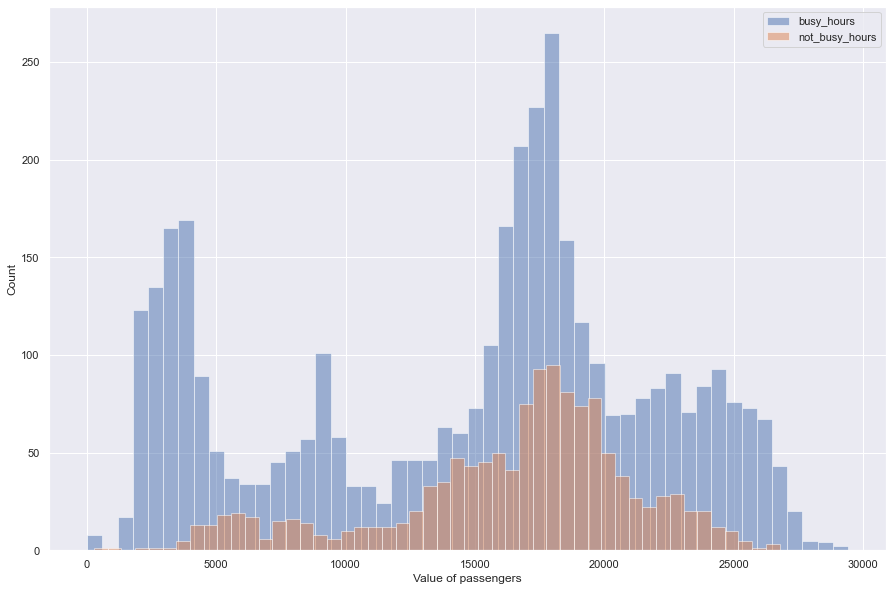

In [170]:
plt.figure(figsize=(15, 10))
plt.hist(a, bins = 50, alpha=0.5, label='busy_hours')
plt.hist(b, bins = 50, alpha=0.5, label='not_busy_hours')
plt.legend(loc='upper right')
plt.xlabel('Value of passengers')
plt.ylabel('Count')
plt.show();

# Алгоритм пошуку анoмалій за допомогою kMeans

# Визначаємо оптимальну кількість кластерів

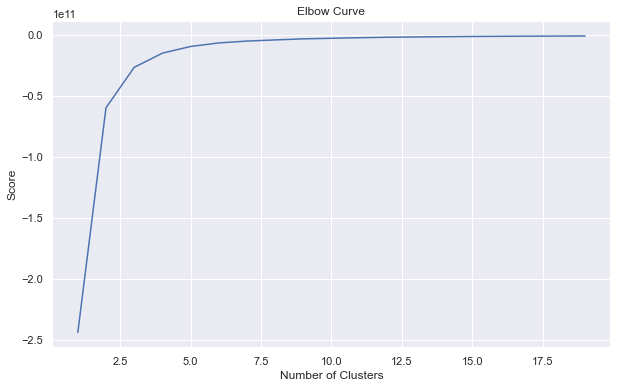

In [171]:
data = df2[['value', 'hour', 'busy_time_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

# З отриманої кривої видно, що оптимальним є використання 8 кластерів

In [172]:
X = df2[['value', 'hour', 'busy_time_bool']]
X = X.reset_index(drop=True)

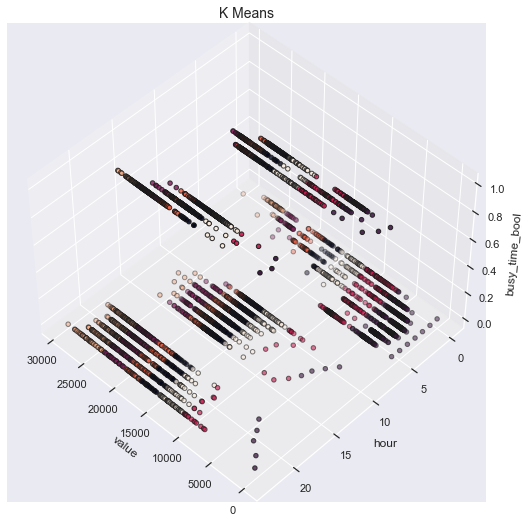

In [173]:
km = KMeans(n_clusters=7)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("value")
ax.set_ylabel("hour")
ax.set_zlabel("busy_time_bool")
plt.title("K Means", fontsize=14);

In [174]:
data = df2[['value', 'hour', 'busy_time_bool']]
X = data.values

# Визначемо кількість головних компонент

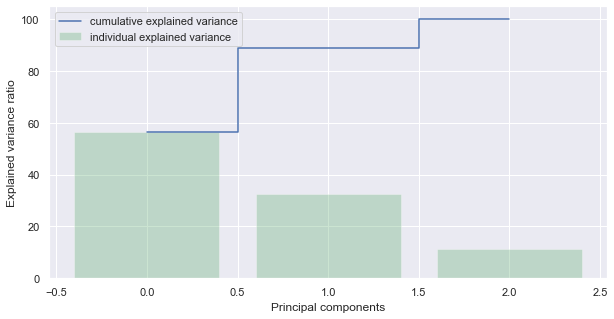

In [175]:
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Значення дисперсії для кожного компонента
cum_var_exp = np.cumsum(var_exp) # Наростаюче значення дисперсії

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

# Інформація зосереджена більше ніж  в 88 процентах даних, а решту можна вважати аномаліями

In [176]:
# Візьмемо основні фічі і стандартизуємо їх
data =  df2[['value', 'hour', 'busy_time_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# залишимо лише дві головні компоненти
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# стандартизуємо їх
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [177]:
# додаємо значення головних компонентів та номери кластерів до основного датасету
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df2['cluster'] = kmeans[7].predict(data)
df2['principal_feature1'] = data[0].values
df2['principal_feature2'] = data[1].values
df2['cluster'].value_counts()

2    984
1    843
3    819
7    794
6    592
0    466
5    429
4    232
Name: cluster, dtype: int64

In [178]:
df2.head()

,value,hour,busy_time_bool,cluster,principal_feature1,principal_feature2
timestamp,,,,,,
2014-07-01 00:00:00,9485.5,0,0,2,1.408769,-0.209412
2014-07-01 01:00:00,5433.0,1,0,2,1.647155,-0.163247
2014-07-01 02:00:00,3346.5,2,0,2,1.732641,-0.150767
2014-07-01 03:00:00,2216.5,3,0,2,1.743736,-0.154675
2014-07-01 04:00:00,2189.5,4,0,2,1.669049,-0.177482


# Обчислюємо значення відстані від найближчого центрїду до кожної точки, найбільші відстані позначимо як аномалії

In [179]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# Обчислюємо значення відстані від найближчого центрїду до кожної точки, найбільші відстані позначимо як аномалії
distance = getDistanceByPoint(data, kmeans[7])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

In [180]:
# 1 - аномалія, 0 - не аномалія
df2['anomaly1'] = (distance >= threshold).astype(int).values

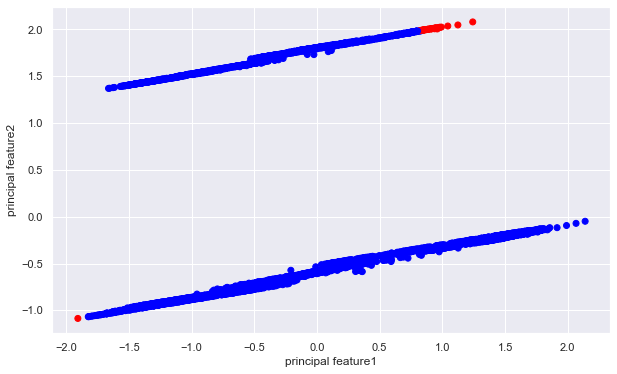

In [181]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df2['principal_feature1'], df2['principal_feature2'], c=df2["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

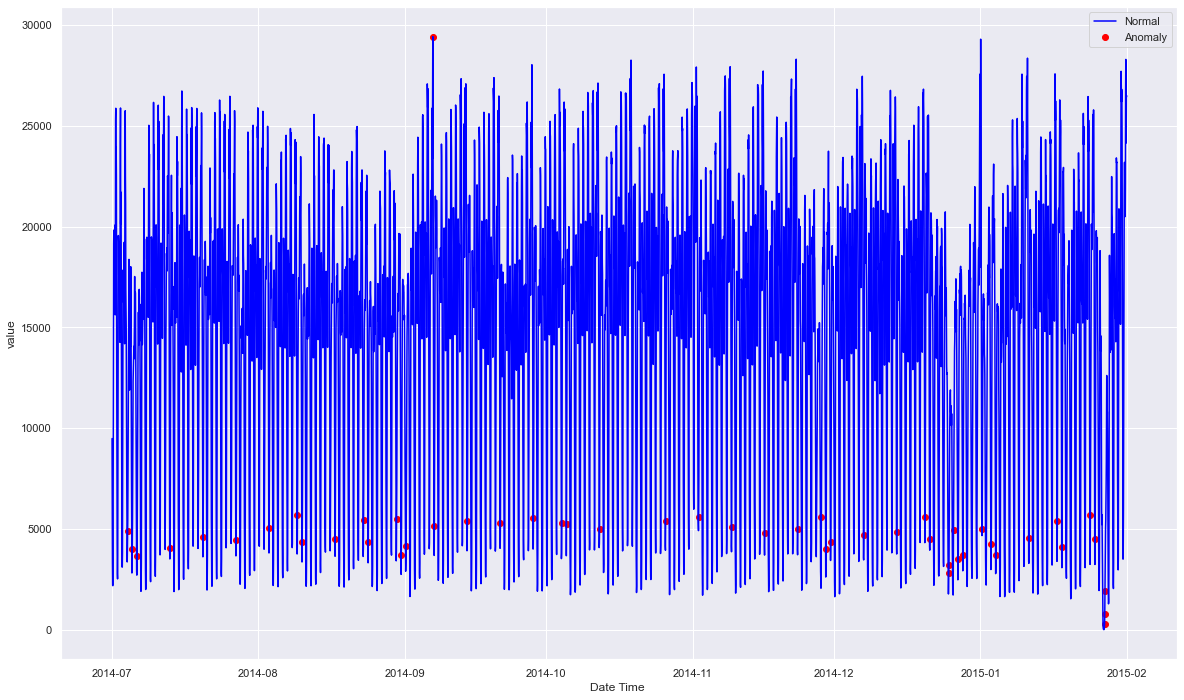

In [182]:
fig, ax = plt.subplots(figsize=(20,12))

a = df2.loc[df2['anomaly1'] == 1, ['value', 'hour']] #аномалії

ax.plot(df2.index, df2['value'], color='blue', label='Normal')
ax.scatter(a.index,a['value'], color='red', label='Anomaly')
plt.xlabel('Date Time ')
plt.ylabel('value')
plt.legend()
plt.show();

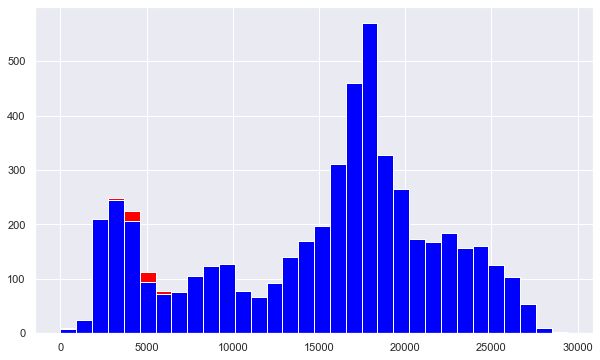

In [183]:
a = df2.loc[df2['anomaly1'] == 0, 'value']
b = df2.loc[df2['anomaly1'] == 1, 'value']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

# Декомпозиція часового ряду та пошук аномалій по residuals з використанням нормального розподілу

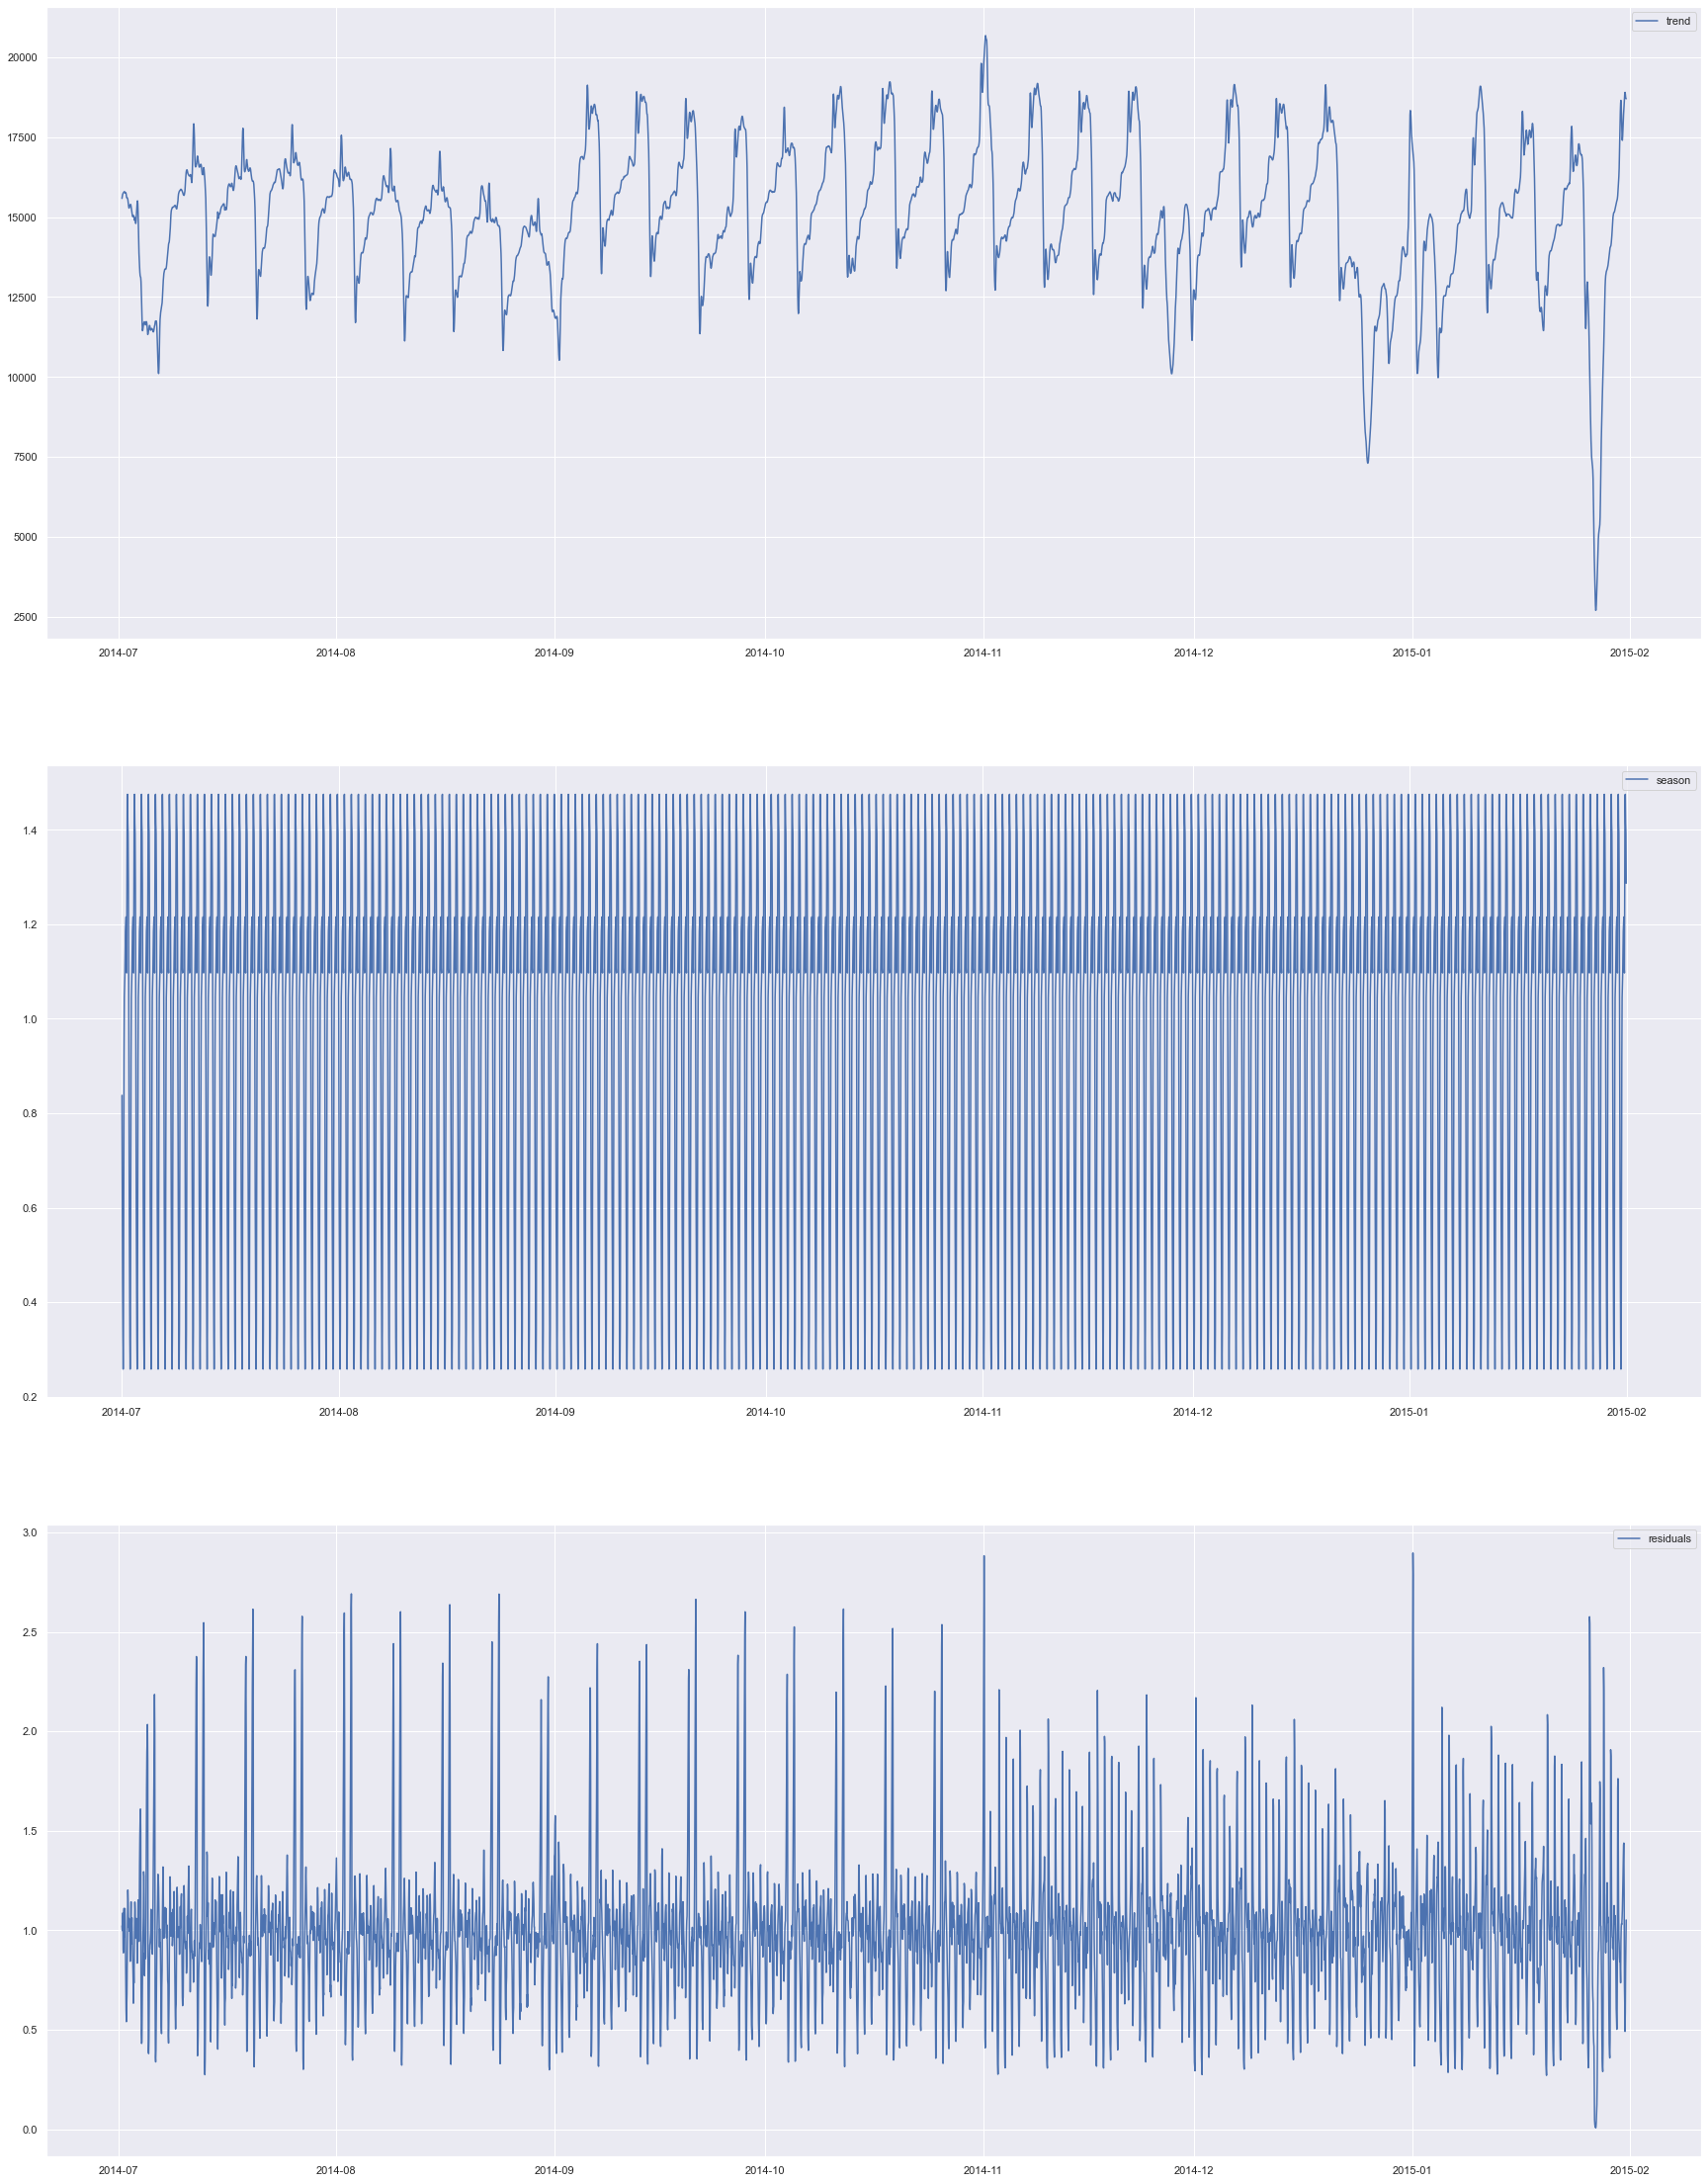

In [184]:
result=seasonal_decompose(df2['value'], model='multiplicable', period=24)

fig, ax = plt.subplots(3,1, figsize=(30, 40))

ax[0].plot(result.trend, label='trend')
ax[0].legend()
ax[1].plot(result.seasonal, label='season')
ax[1].legend()
ax[2].plot(result.resid, label='residuals')
ax[2].legend()
plt.show()

In [187]:
residuals = result.resid.dropna()
envelope =  EllipticEnvelope(contamination=0.01) 
X_train_res = residuals.values.reshape(-1,1)
envelope.fit(X_train_res)
residuals = pd.DataFrame(residuals)
residuals['deviation'] = envelope.decision_function(X_train_res)
residuals['anomaly'] = envelope.predict(X_train_res)

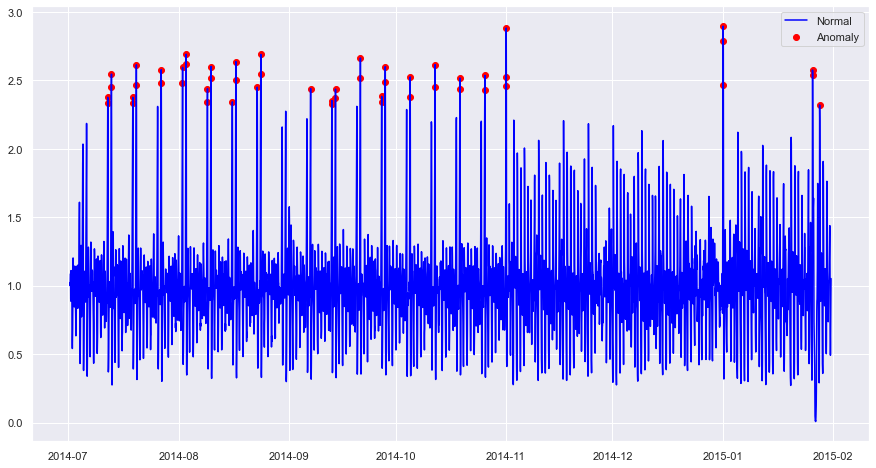

In [188]:
fig, ax = plt.subplots(figsize=(15, 8))
a = residuals.loc[residuals['anomaly'] == -1, ('resid')] #anomaly
ax.plot(residuals.index, residuals['resid'], color='blue', label='Normal')
ax.scatter(a.index, a.values, color='red', label='Anomaly')
plt.legend()
plt.show()

# Пошук аномалій по в часовому ряді з використанням нормального розподілу

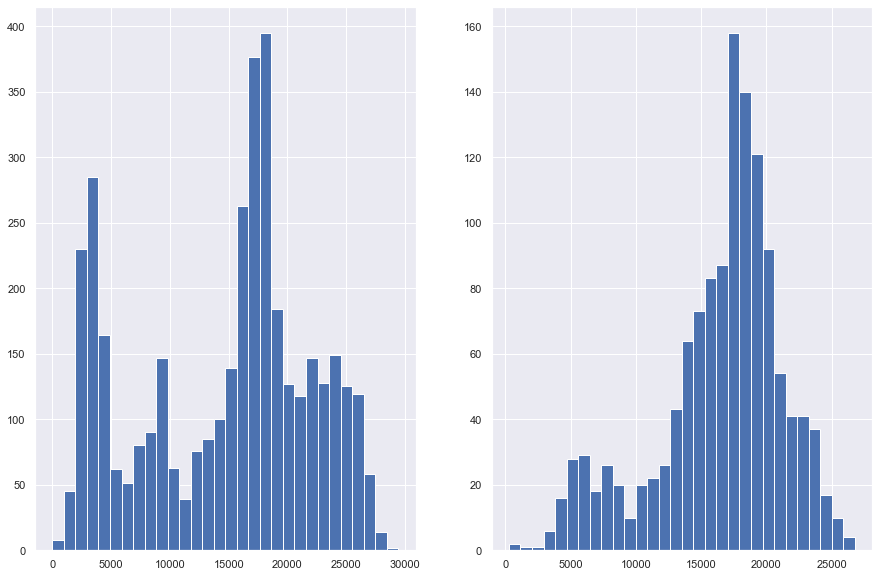

In [193]:
df_class0 = df2.loc[df2['busy_time_bool'] == 0, 'value']
df_class1 = df2.loc[df2['busy_time_bool'] == 1, 'value']

fig, axs = plt.subplots(1,2)
df_class0.hist(ax=axs[0], bins=30)
df_class1.hist(ax=axs[1], bins=30);

In [194]:
envelope =  EllipticEnvelope(contamination=0.01) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination=0.01) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

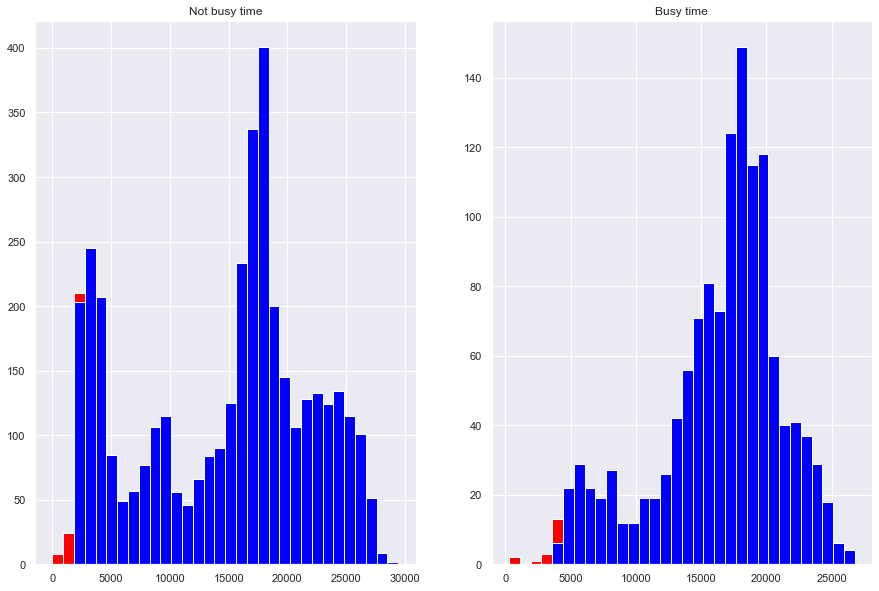

In [195]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

fig, axs = plt.subplots(1,2)
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[0].set_title("Not busy time")
axs[1].set_title("Busy time")
plt.show();

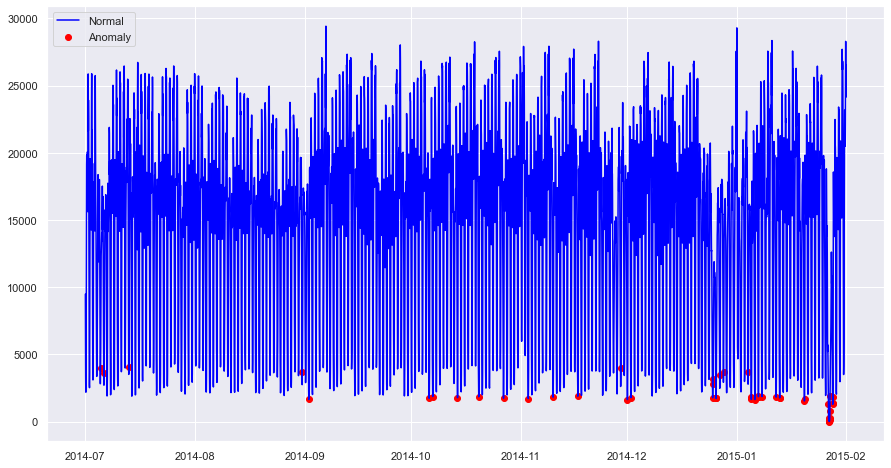

In [196]:
df_class = pd.concat([df_class0, df_class1])
df2['anomaly5'] = df_class['anomaly']

fig, ax = plt.subplots(figsize=(15, 8))
a = df2.loc[df2['anomaly5'] == -1, ('value')] 
                                    #anomaly
ax.plot(df2.index, df2['value'], color='blue', label='Normal')
ax.scatter(a.index,a.values, color='red', label='Anomaly')
plt.legend()
plt.show();


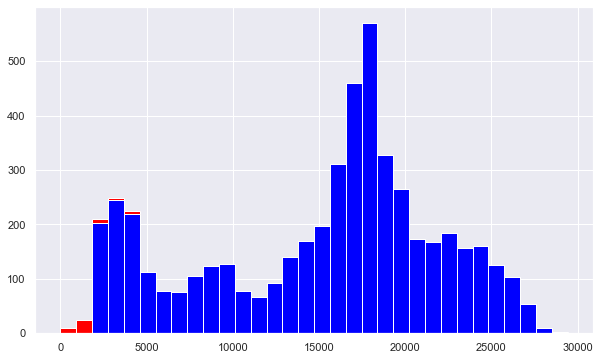

In [197]:
a = df2.loc[df2['anomaly5'] == 1, 'value']
b = df2.loc[df2['anomaly5'] == -1, 'value']

fig, axs = plt.subplots(figsize=(10, 6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();